## importando a base de dados nescessaria

In [1]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

### Funções

In [3]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
data = pd.read_parquet(bucket_uri)

In [6]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [7]:
data['id'].nunique()

30490

In [8]:
data['item_id'].nunique()

3049

In [9]:
data['dept_id'].nunique()

7

In [10]:
data['cat_id'].nunique()

3

In [11]:
data['store_id'].nunique()

10

In [12]:
data['state_id'].nunique()

3

In [13]:
data['date'] = pd.to_datetime(data['date'])

In [14]:
data = data.set_index('date')

## Previsão por departamento (dept_id)✅


In [15]:
df_dept_id = data.groupby(['dept_id']).resample('M')['value'].sum()

In [16]:
df_dept_id.to_frame()

value
dept_id     date             
FOODS_1     2011-01-31   6216
            2011-02-28  54155
            2011-03-31  53527
            2011-04-30  50678
            2011-05-31  47358
...                       ...
HOUSEHOLD_2 2016-01-31  54109
            2016-02-29  56897
            2016-03-31  60211
            2016-04-30  62673
            2016-05-31  49305

[455 rows x 1 columns]

In [17]:
df_dept_id_reset_index = df_dept_id.reset_index()

In [18]:
df_nixtla_3 = pd.DataFrame({
    'unique_id': df_dept_id_reset_index['dept_id'],
    'ds': df_dept_id_reset_index['date'],
    'y': df_dept_id_reset_index['value']
})

In [19]:
df_nixtla_3

,unique_id,ds,y
0,FOODS_1,2011-01-31,6216
1,FOODS_1,2011-02-28,54155
2,FOODS_1,2011-03-31,53527
3,FOODS_1,2011-04-30,50678
4,FOODS_1,2011-05-31,47358
...,...,...,...
450,HOUSEHOLD_2,2016-01-31,54109
451,HOUSEHOLD_2,2016-02-29,56897
452,HOUSEHOLD_2,2016-03-31,60211
453,HOUSEHOLD_2,2016-04-30,62673


In [20]:
df_nixtla_3['ds'] = pd.to_datetime(df_nixtla_3['ds'])

In [21]:
df_nixtla_3['unique_id'].value_counts().sum()

455

In [22]:
df_test = df_nixtla_3.groupby('unique_id').tail(6)
df_train = df_nixtla_3.drop(df_test.index)

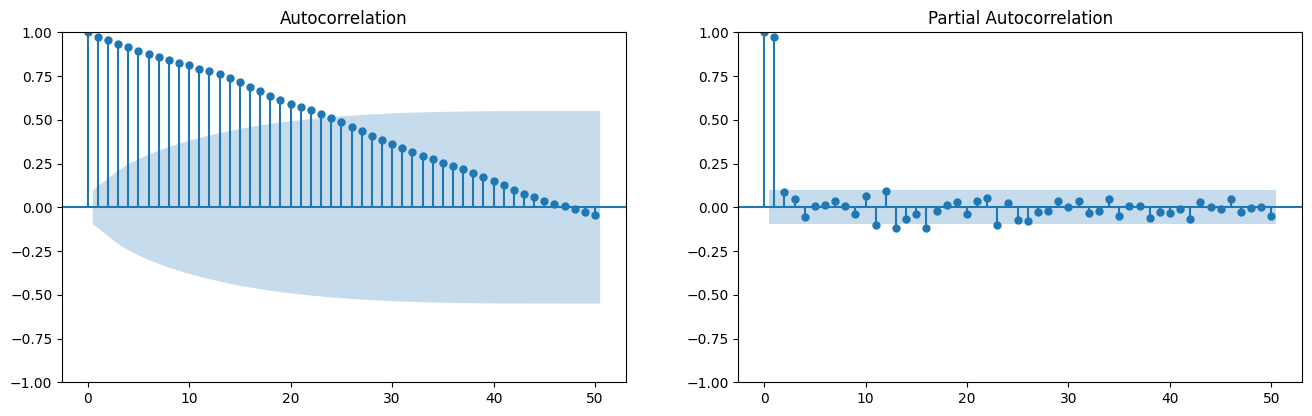

In [23]:
acf_pacf(df_train['y'], 50)

In [24]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

In [25]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[x for x in range(1, 23)],
)

In [26]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1914
[LightGBM] [Info] Number of data points in the train set: 259, number of used features: 22
[LightGBM] [Info] Start training from score 157881.235521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

MLForecast(models=[RandomForestRegressor, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor, LGBMRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22'], date_features=[], num_threads=1)

In [27]:
len(df_test)

42

In [28]:
predict = fcst.predict(6)


In [29]:
for i in list(models.keys()):
  predict[i] = predict[i].astype(int)

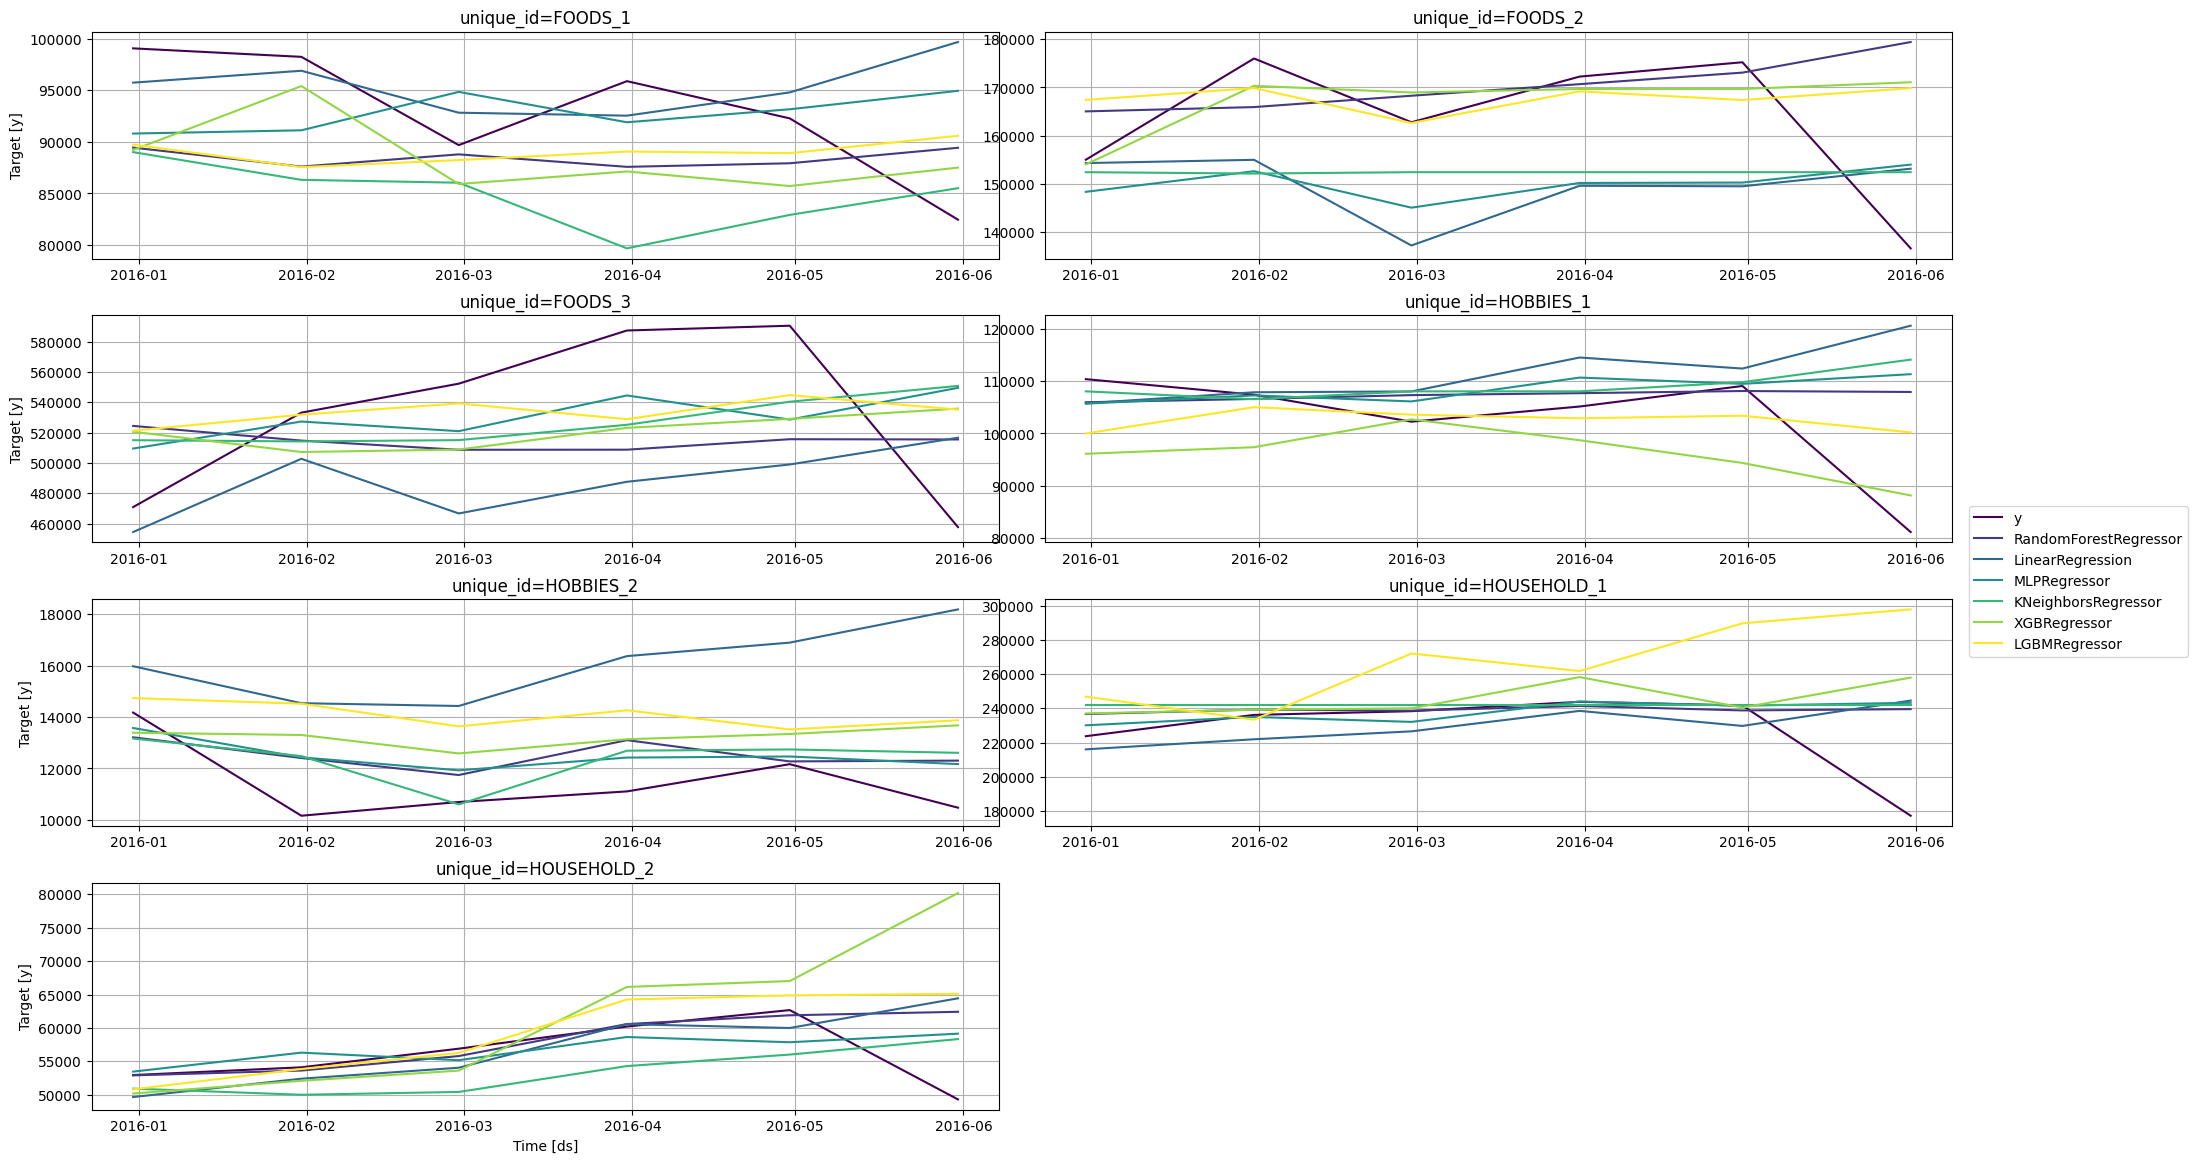

In [30]:
plot_series(df_test, predict, plot_random=False)

In [31]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], predict[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], predict[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], predict[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], predict[i])
  print(f'R2: {R2}')
  print('\n')

------------------RandomForestRegressor-----------------
Mean Absolute Error: 14000.47619047619
Mean absolute percentage error: 0.08347995050346124
Root mean squared error: 25655.83680364447
R2: 0.9752935266300726


------------------LinearRegression-----------------
Mean Absolute Error: 18102.071428571428
Mean absolute percentage error: 0.14379011537929212
Root mean squared error: 31004.427246458727
R2: 0.96391839771001


------------------MLPRegressor-----------------
Mean Absolute Error: 13693.857142857143
Mean absolute percentage error: 0.08659044400604204
Root mean squared error: 24291.438031105685
R2: 0.977851473426043


------------------KNeighborsRegressor-----------------
Mean Absolute Error: 15194.714285714286
Mean absolute percentage error: 0.09717171802143054
Root mean squared error: 25437.76523016049
R2: 0.9757117458306578


------------------XGBRegressor-----------------
Mean Absolute Error: 15321.52380952381
Mean absolute percentage error: 0.10856981469436322
Root mean s

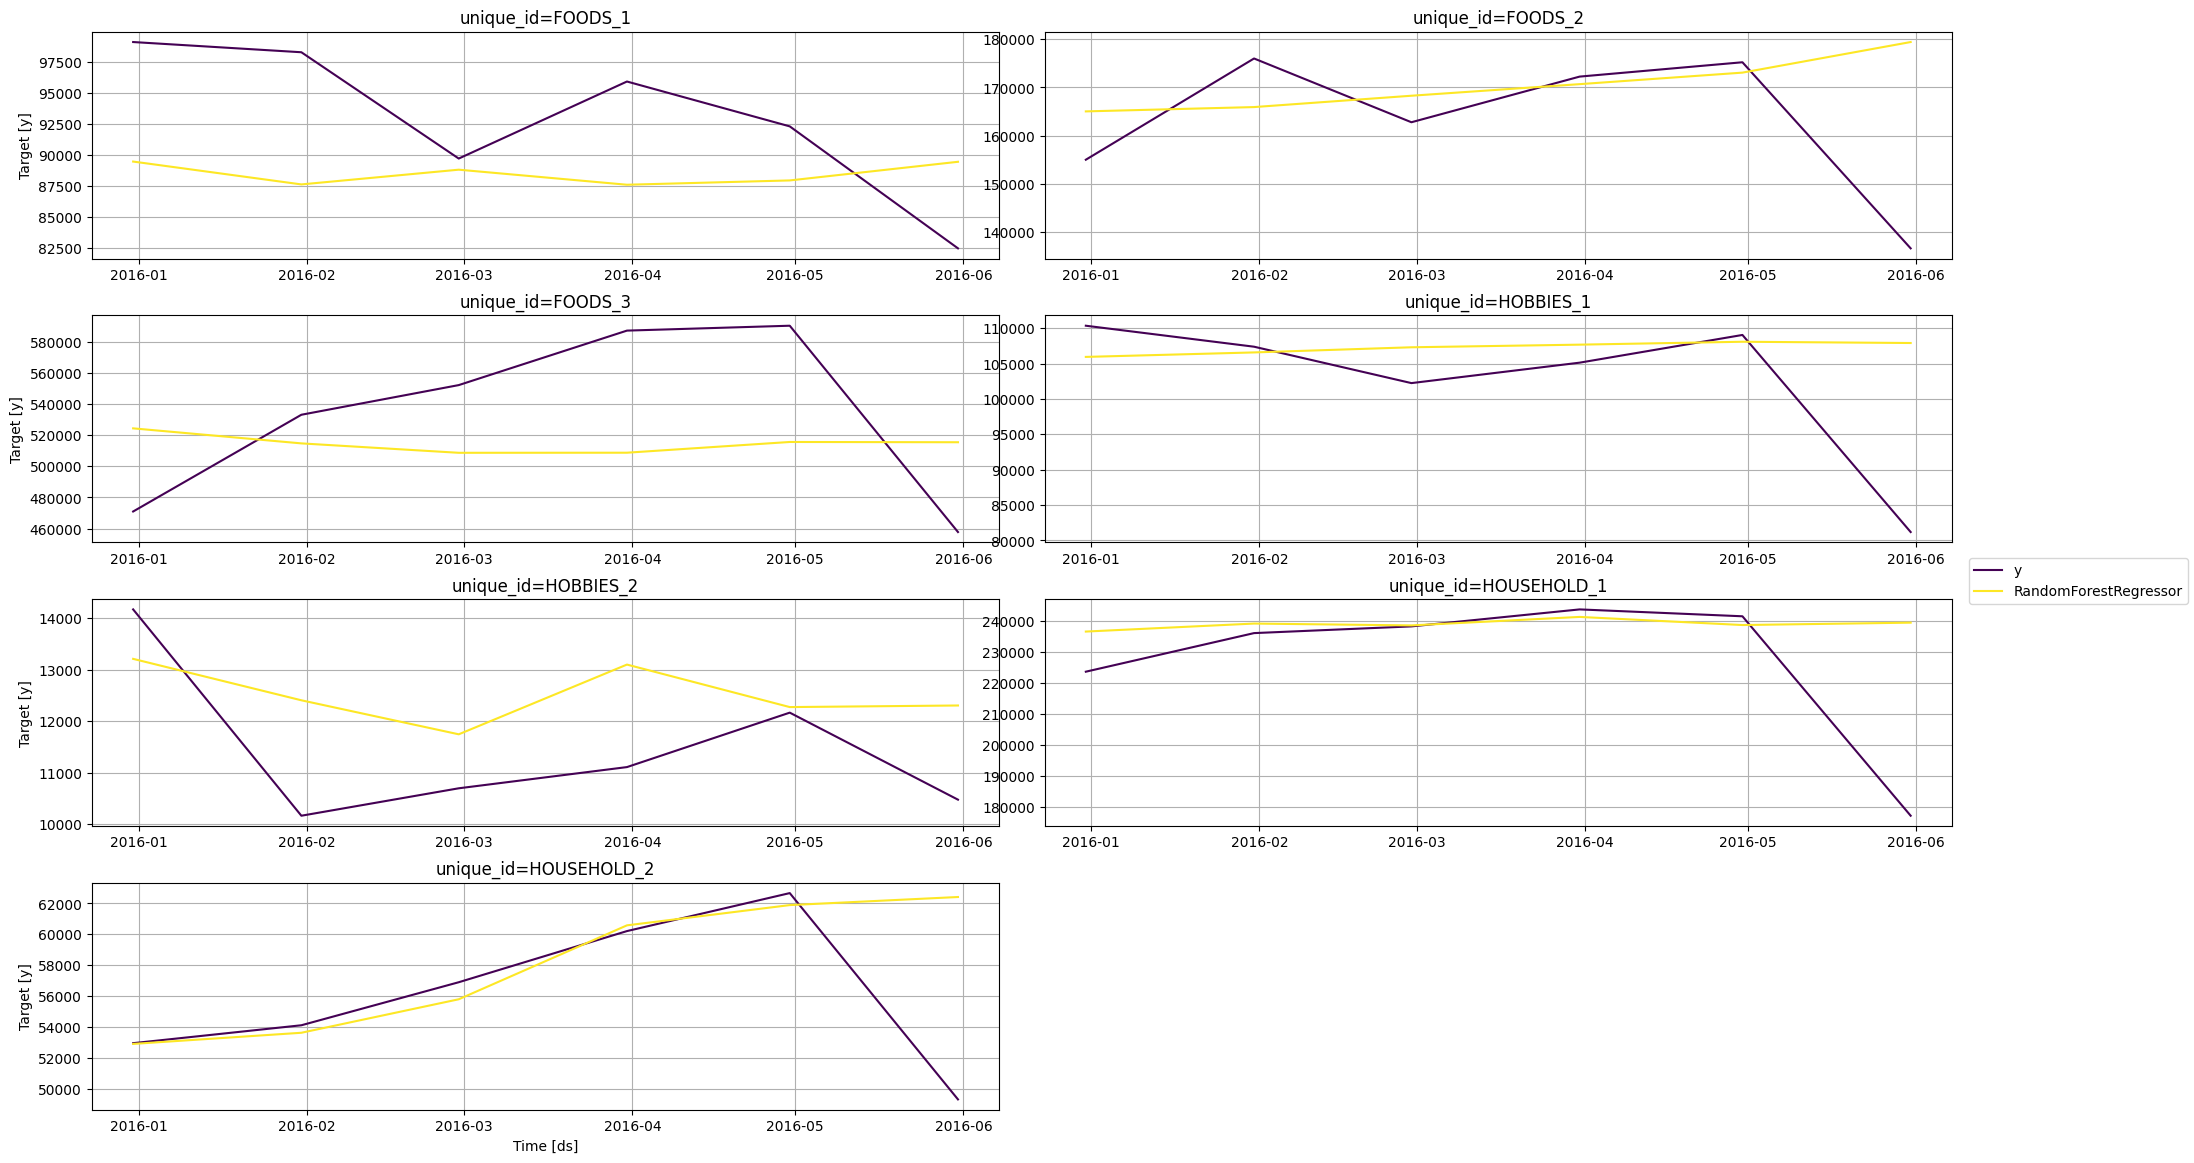

In [32]:
plot_series(df_test, predict[['unique_id', 'ds', 'RandomForestRegressor']], plot_random=False)

In [33]:
previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()


,unique_id,ds,y,RandomForestRegressor,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor
0,FOODS_1,2015-12-31,99072,89448,95748,90811,89010,89216,89736
1,FOODS_1,2016-01-31,98250,87608,96900,91126,86322,95416,87558
2,FOODS_1,2016-02-29,89691,88794,92833,94851,86044,85917,88240
3,FOODS_1,2016-03-31,95893,87582,92546,91904,79678,87136,89067
4,FOODS_1,2016-04-30,92282,87929,94802,93167,82923,85720,88914


In [34]:
previsao.to_csv('treinamento/treino_departamento_treino.csv')

Treinando o melhor modelo

In [35]:
models = {
    'RandomForestRegressor' : RandomForestRegressor()
}

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 6, 12]
)

dados_full = pd.concat([df_train, df_test])
fcst.fit(dados_full)



MLForecast(models=[RandomForestRegressor], freq=MS, lag_features=['lag1', 'lag6', 'lag12'], date_features=[], num_threads=1)

In [36]:
import pickle
with open('Modelos/modelo_previsao_departamento.pkl', 'wb') as file:
    pickle.dump(fcst, file)

In [37]:
previsao = fcst.predict(6)
previsao['RandomForestRegressor'] = previsao['RandomForestRegressor'].astype(int)
previsao

,unique_id,ds,RandomForestRegressor
0,FOODS_1,2016-06-01,91972
1,FOODS_1,2016-07-01,90720
2,FOODS_1,2016-08-01,89338
3,FOODS_1,2016-09-01,88650
4,FOODS_1,2016-10-01,89119
5,FOODS_1,2016-11-01,92217
6,FOODS_2,2016-06-01,145236
7,FOODS_2,2016-07-01,159820
8,FOODS_2,2016-08-01,164398
9,FOODS_2,2016-09-01,168008


In [38]:
previsao.to_csv('previsao/previsao_departamento_RandomForestRegressor.csv')